In [ ]:
# tiny reconstruction module here to ass the problem of cosine
# Importing libraries 
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\single_image"

net_name = "alexnet"
layer_name = ".features.Conv2d10"#".features.Conv2d8"#".features.Conv2d10"
layer_short = "conv1"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 256
score_method = "Correlation"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
for imgid in range(len(refimgnms)):
    targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
    G = upconvGAN(gan_name).cuda()
    G.requires_grad_(False)
    code_length = G.codelen

    scorer_random = TorchScorer(net_name)
    module_names, module_types, module_spec = get_module_names(
            scorer_random.model, input_size, "cuda", False)
    pop_resampling_id = 0
    unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
                        scorer_random, [layer_name], popsize=popsize, seed=pop_resampling_id)
    fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)
    targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                            RFresize=True, corner=pading_size, imgsize=img_size)
    targlabel = os.path.splitext(targnm)[0]

    target_imgtsr_resized_RF_masked =\
            (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
            target_imgtsr_resized

    # showt the tensor image 
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
    ax.axis("off")
    ax.set_title(targlabel)
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
    ax.axis("off")
    ax.set_title(targlabel)
    plt.show()


    title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
    #set objective function
    objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
    ## set optimizer
    optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                    init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                    maximize=True, random_seed=None, optim_params={})

    codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
            run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
            titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
    # 
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
    ax.axis("off")
    ax.set_title(targlabel)
    plt.show()

    figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
    trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                    title_str=title_str)
    scorer_random.cleanup()


In [17]:
get_module_names(
            scorer_random.model, input_size, "cuda", False)

(OrderedDict([('0', 'Image'),
              ('1', '.features.Conv2d0'),
              ('2', '.features.ReLU1'),
              ('3', '.features.MaxPool2d2'),
              ('4', '.features.Conv2d3'),
              ('5', '.features.ReLU4'),
              ('6', '.features.MaxPool2d5'),
              ('7', '.features.Conv2d6'),
              ('8', '.features.ReLU7'),
              ('9', '.features.Conv2d8'),
              ('10', '.features.ReLU9'),
              ('11', '.features.Conv2d10'),
              ('12', '.features.ReLU11'),
              ('13', '.features.MaxPool2d12'),
              ('14', '.features'),
              ('15', '.AdaptiveAvgPool2davgpool'),
              ('16', '.classifier.Dropout0'),
              ('17', '.classifier.Linear1'),
              ('18', '.classifier.ReLU2'),
              ('19', '.classifier.Dropout3'),
              ('20', '.classifier.Linear4'),
              ('21', '.classifier.ReLU5'),
              ('22', '.classifier.Linear6'),
              ('23'

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


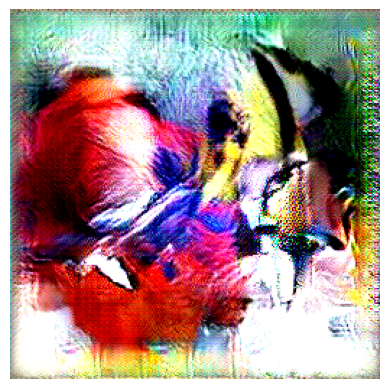

In [2]:
# tiny reconstruction module here to ass the problem of cosine
# Importing libraries 
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
import torch
import numpy as np
from core.utils.CNN_scorers import TorchScorer
from core.utils.Optimizers import CholeskyCMAES
from core.utils.GAN_utils import upconvGAN
from core.utils.layer_hook_utils import get_module_names
import matplotlib.pylab as plt
from core.utils.func_lib import *

scorer = TorchScorer("alexnet", imgpix=224)
h = scorer.set_unit("score", ".classifier", (749,), ingraph=False)
G = upconvGAN("fc6").cuda().eval()
new_codes = np.random.randn(1, 4096)
optimizer = CholeskyCMAES(space_dimen=4096, init_code=new_codes, init_sigma=3.0,)
steps = 20
for i in range(steps):
    latent_code = torch.from_numpy(np.array(new_codes)).float()
    imgs = G.visualize(latent_code.cuda()).cpu()
    scores = scorer.score_tsr(imgs)
    new_codes = optimizer.step_simple(scores, new_codes, )
    # print each 20 run 
    #print("step %d score %.3f (%.3f) (norm %.2f )" % (
    #           i, scores.mean(), scores.std(), latent_code.norm(dim=1).mean(),))
        
    # 

plt.imshow(ToPILImage()(imgs[np.argmax(scores)]))
plt.axis("off")
plt.show()

In [3]:
scores

array([ 7.95082235,  9.04599762,  7.82474566,  8.70411205,  6.94626188,
        7.52630472, 10.01794338, 10.25771332,  8.92226219, 11.64203167,
        8.7217865 , 11.11528587, 10.4717865 ,  9.03126335,  8.15577316,
        9.80454445,  6.62610054, 11.0844059 ,  5.00042868, 10.80810547,
        8.16455746, 10.75324154,  9.12217808,  7.4946332 ,  8.56959152,
        8.18882275,  8.272439  ,  7.30984688,  8.15615368,  8.9751873 ,
       11.26968861,  4.57540751,  9.38500595,  8.35335064,  6.22545767,
        8.32411003,  7.42769194,  7.04145384,  8.76944256, 13.98069   ])

In [ ]:
# tiny reconstruction module here to ass the problem of cosine
# Importing libraries 
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\single_image"

net_name = "alexnet"
layer_name = [".features.Conv2d10", 
layer_short = "conv1"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (187, 187)
pading_size = (20, 20) 
popsize = 192
score_method = "MSE"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
for imgid in range(len(refimgnms)):
    targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
    G = upconvGAN(gan_name).cuda()
    G.requires_grad_(False)
    code_length = G.codelen

    scorer_random = TorchScorer(net_name)
    module_names, module_types, module_spec = get_module_names(
            scorer_random.model, input_size, "cuda", False)
    pop_resampling_id = 0
    unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
                        scorer_random, [layer_name], popsize=popsize, seed=pop_resampling_id)

    targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                            RFresize=True, corner=pading_size, imgsize=img_size)
    targlabel = os.path.splitext(targnm)[0]


    # showt the tensor image in a subplot
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(ToPILImage()(target_imgtsr[0]))
    ax.axis("off")
    ax.set_title(targlabel)
    plt.show()

    

    title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
    #set objective function
    objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
    ## set optimizer
    optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                    init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                    maximize=True, random_seed=None, optim_params={})

    codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
            run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
            titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=None, save_plot=None)
    # 

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(ToPILImage()(last_gem_img.mean(dim=0)))
    ax.axis("off")
    ax.set_title(targlabel)
    ax.set_title(f"score: {best_scores[0]:.3f}")
    plt.show()

    figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
    trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                    title_str=title_str)
    scorer_random.cleanup()
    # open a new figure

In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\tiny_set_image"

net_name = "alexnet"
layer_name = ['.features.Conv2d10']#, '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "conv5"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 256
score_method = "cosine_norm_diff"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 2

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
#unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
#                scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()


Image
.features.Conv2d0
.features.ReLU1
.features.MaxPool2d2
.features.Conv2d3
.features.ReLU4
.features.MaxPool2d5
.features.Conv2d6
.features.ReLU7
.features.Conv2d8
.features.ReLU9
.features.Conv2d10
.features.ReLU11
.features.MaxPool2d12
.features
.AdaptiveAvgPool2davgpool
.classifier.Dropout0
.classifier.Linear1
.classifier.ReLU2
.classifier.Dropout3
.classifier.Linear4
.classifier.ReLU5
.classifier.Linear6
.classifier
.AlexNet


KeyError: 

In [20]:
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())


final MSE score:  25.37775


array([[ -3.1758785 ,   5.4694405 ,  10.832824  ,  -3.7084088 ,
         10.795259  ,   7.802531  ,  -7.114769  ,   4.497532  ,
         -0.6432862 ,   4.195686  ,  -1.8465571 ,  -1.946383  ,
          2.9077775 ,   0.03893757,  -2.4127164 ,  -0.18734407,
          1.8596234 ,  -3.4273863 ,  -0.94900894,   9.333355  ,
         -1.1108027 ,  -3.5368295 ,  -1.2754908 ,  -1.8010263 ,
         -2.4137363 ,   0.19168425,  -2.110734  ,   0.18100214,
         -2.1159258 ,  -5.052758  ,   2.5019026 ,  -3.115591  ,
         -2.5910115 ,  -2.3450356 ,   2.3096871 ,   1.4909033 ,
        -12.088551  ,   7.7857704 ,  -3.0779543 ,   4.9791107 ,
          4.4815593 ,   3.8172464 ,  -6.46035   ,   2.6860476 ,
          0.11682224,  -7.285571  ,  -2.1180413 ,   0.786046  ,
         -0.85916114,  -0.7592211 ,   2.4249763 ,  -1.6601359 ,
         -6.2090697 ,  -4.002332  ,   2.8637962 ,   4.8255672 ,
          0.4136604 ,  -2.8280852 ,  -3.573544  ,  11.04983   ,
         -0.613977  ,  -3.2408435 ,  -0.

Gaussian Fitting center (111.1, 111.5)
 Cov mat XX 800.1 YY 818.9 XY 1.0
act mat shape:  (1, 128)
act mat shape:  (1, 128)


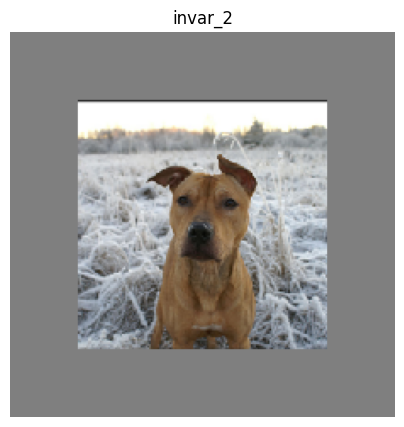

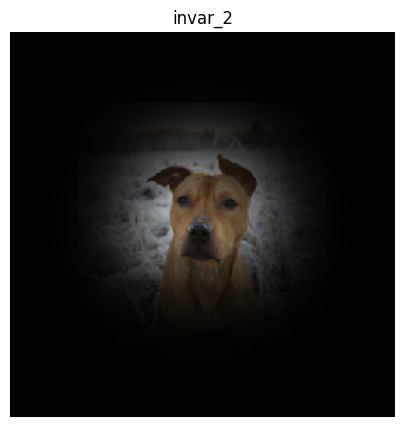

Space dimension: 256, Population size: 28, Select size:14, Optimization Parameters:
Initial sigma: 0.250
cc=0.015, cs=0.151, c1=0.000 damps=1.151
:-------------------->  invar_2.JPEG-128-MSE-conv1-BigGAN evol finished! best score: -31.435
plot not saved


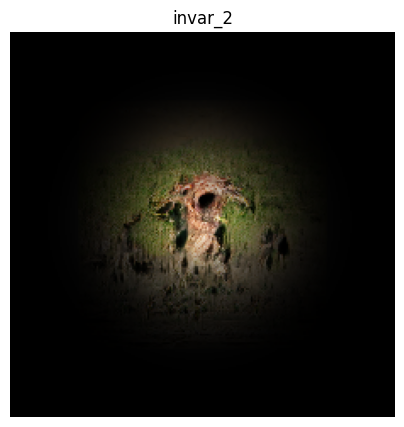

Cleanuping...
Cleanup hooks done.
Cleanup done.


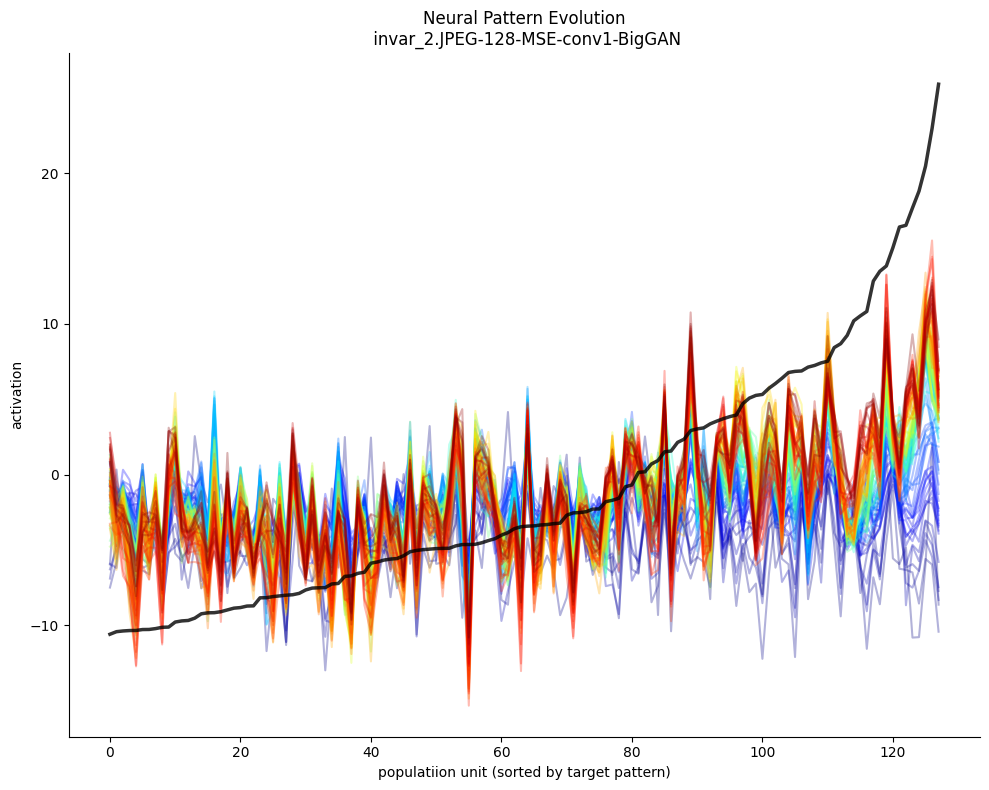

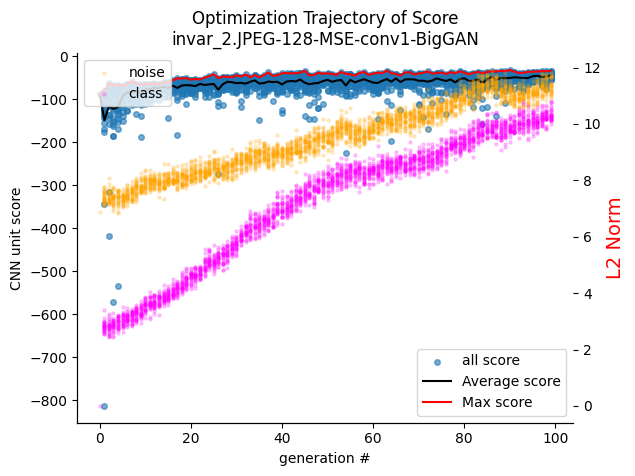

In [2]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN, loadBigGAN, BigGAN_wrapper, load_Hessian
from core.utils.Optimizers import *
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
from pytorch_pretrained_biggan import truncated_noise_sample
#%%
# 

refimgdir = r"C:\Data\cosine\insilico_experiments\data\single_image"
Hdir_BigGAN = r"N:\PonceLab\Data-Computational\Hessian_summary\BigGAN\H_avg_1000cls.npz"
Hdir_fc6 = r"N:\PonceLab\Data-Computational\Hessian_summary\fc6GAN\Evolution_Avg_Hess.npz"

net_name = "alexnet"
layer_name = ['.features.Conv2d10']
#layer_name = ['.features.Conv2d10', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']
layer_short = "conv1"
gan_name = "BigGAN"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 128
score_method = "MSE"

Hdata = load_Hessian(gan_name, Hdir_BigGAN)
eva = Hdata['eigvals_avg'][::-1]
evc = Hdata['eigvects_avg'][:, ::-1]

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 2

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]

BGAN = loadBigGAN()
G = BigGAN_wrapper(BGAN)
code_length = 256
fixnoise = 0.7 * truncated_noise_sample(1, 128, seed=0)
init_code = np.concatenate((fixnoise, np.zeros((1, 128))), axis=1)

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 1
#unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
#               scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)

unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random,
                               layer_name, input_size,show_fig=False, gan_name=gan_name)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)

target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer vanila CMAES
optimizer = CholeskyCMAES(code_length, init_sigma=.25,
                init_code=init_code, Aupdate_freq=102)
## set optimizer with Hessian
#optimizer = HessCMAES(code_length, init_code=init_code, init_sigma=0.3)
#optimizer.set_Hessian(eigvals=eva, eigvects=evc, expon=1 / 2.5)

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None,
        init_code = init_code)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs_RF_masked[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()

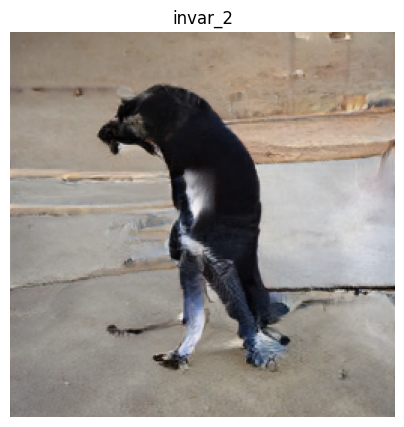

In [12]:
#fixnoise = np.zeros((1, 128))
fixnoise = 0.7 * truncated_noise_sample(1, 128, seed=1)
init_code = np.concatenate((fixnoise, np.zeros((1, 128))), axis=1)
imgs = G.visualize_batch_np(init_code) 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(imgs[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()